Train and analyse Hierarchy in a feed forward ANN

In [50]:
import torch
import torch.nn as nn 
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt 
input_size = 784 # 28x28
hidden_size = [500, 300, 100, 100, 10]
num_classes = 10
num_epochs = 6
batch_size = 100
learning_rate = 1e-4
device = 'cpu'

In [3]:
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                            train=True, 
                                       transform=transforms.ToTensor(),  
                                           download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', 
                                        train=False, 
                                        transform=transforms.ToTensor()) 


# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                        batch_size=batch_size, 
                                        shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                        batch_size=batch_size, 
                                        shuffle=False) 


100%|██████████| 9912422/9912422 [00:00<00:00, 39112006.82it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 40554299.91it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 17612925.68it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 9789583.13it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [62]:


# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size: list, num_classes):
        super(NeuralNet, self).__init__()
        self.input_size = input_size
        self.hidden = nn.ModuleList([nn.Linear(input_size, hidden_size[0]), nn.ReLU()])
        for i, hs in enumerate(hidden_size[1:]):
            self.hidden.extend([nn.Linear(hidden_size[i], hs), nn.ReLU()])
        self.out_proj = nn.Linear(hidden_size[-1], num_classes)   


    def forward(self, x):
        hidden_activations = []
        for idx, layer in enumerate(self.hidden):
            x = layer(x)
            if idx % 2 == 0:
                hidden_activations.append(x)
        out = self.out_proj(x)
        # no activation and no softmax at the end
        return out, hidden_activations

In [63]:

model = NeuralNet(input_size, hidden_size, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 


n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # origin shape: [100, 1, 28, 28]
        # resized: [100, 784]
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        # Forward pass
        outputs, _ = model(images)
        loss = criterion(outputs, labels)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() 
        if (i+1) % 100 == 0:
             print (f'Epoch [{epoch+1}/{num_epochs}], Step[{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')



Epoch [1/6], Step[100/600], Loss: 2.0628
Epoch [1/6], Step[200/600], Loss: 1.6791
Epoch [1/6], Step[300/600], Loss: 1.5932
Epoch [1/6], Step[400/600], Loss: 1.7371
Epoch [1/6], Step[500/600], Loss: 1.3902
Epoch [1/6], Step[600/600], Loss: 1.4038
Epoch [2/6], Step[100/600], Loss: 1.1718
Epoch [2/6], Step[200/600], Loss: 1.0299
Epoch [2/6], Step[300/600], Loss: 0.9597
Epoch [2/6], Step[400/600], Loss: 0.8313
Epoch [2/6], Step[500/600], Loss: 0.7662
Epoch [2/6], Step[600/600], Loss: 0.4975
Epoch [3/6], Step[100/600], Loss: 0.4284
Epoch [3/6], Step[200/600], Loss: 0.3429
Epoch [3/6], Step[300/600], Loss: 0.2857
Epoch [3/6], Step[400/600], Loss: 0.2916
Epoch [3/6], Step[500/600], Loss: 0.2809
Epoch [3/6], Step[600/600], Loss: 0.2241
Epoch [4/6], Step[100/600], Loss: 0.2608
Epoch [4/6], Step[200/600], Loss: 0.2270
Epoch [4/6], Step[300/600], Loss: 0.2148
Epoch [4/6], Step[400/600], Loss: 0.2560
Epoch [4/6], Step[500/600], Loss: 0.1263
Epoch [4/6], Step[600/600], Loss: 0.4640
Epoch [5/6], Ste

In [74]:
with torch.no_grad():
     n_correct = 0
     n_samples = 0
     hidden_activities = []
     all_labels = []
     for images, labels in test_loader:
         images = images.reshape(-1, 28*28).to(device)
         labels = labels.to(device)
         outputs, hidden_act = model(images)
         hidden_activities.append(hidden_act)
         all_labels.append(labels)
         # max returns (value ,index)
         _, predicted = torch.max(outputs.data, 1)
         n_samples += labels.size(0)
         n_correct += (predicted == labels).sum().item() 
acc = 100.0 * n_correct / n_samples
print(f'Accuracy of the network on the 10000 test images: {acc} %') 
all_labels = torch.cat(all_labels, 0)

Accuracy of the network on the 10000 test images: 95.12 %


In [ ]:
layers = [model.hidden[0].weight]
prev_layer = layers[0]
for i in range(2, 2*len(hidden_size), 2):
    layers.append(model.hidden[i].weight @ prev_layer)
    prev_layer = layers[-1]
final = model.out_proj.weight @ prev_layer
for i in range(0, len(layers)):
    plt.figure()
    plt.imshow(model.hidden[2*i].weight.detach(), vmax=1e-1, vmin=-1e-1)
    plt.colorbar()
for l in range(len(layers)):
    for i in range(0,3):
        plt.figure()
        plt.imshow(layers[l][i].view(28, 28).detach())
for i in range(10):
    plt.figure()
    plt.imshow(final[i].view(28, 28).detach())

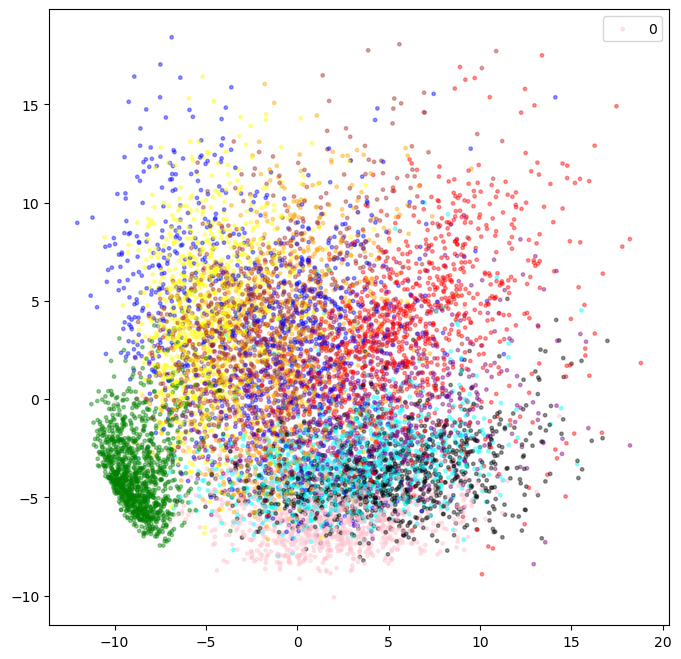

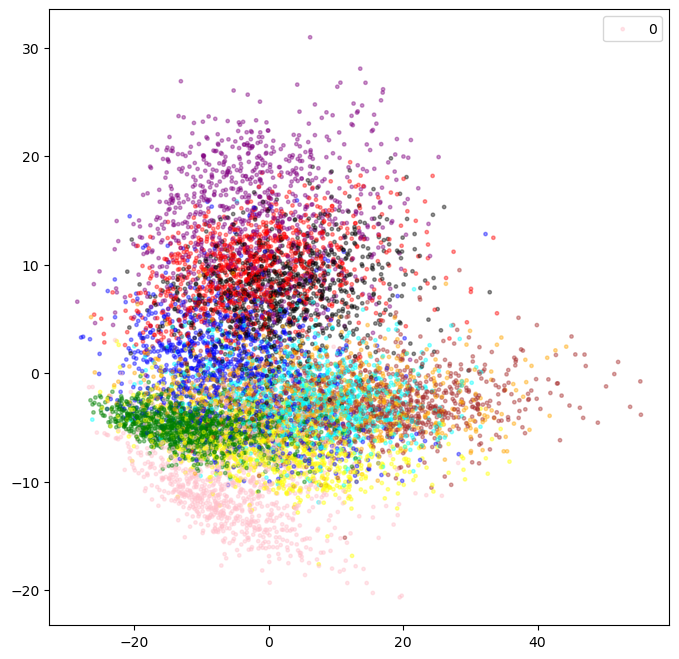

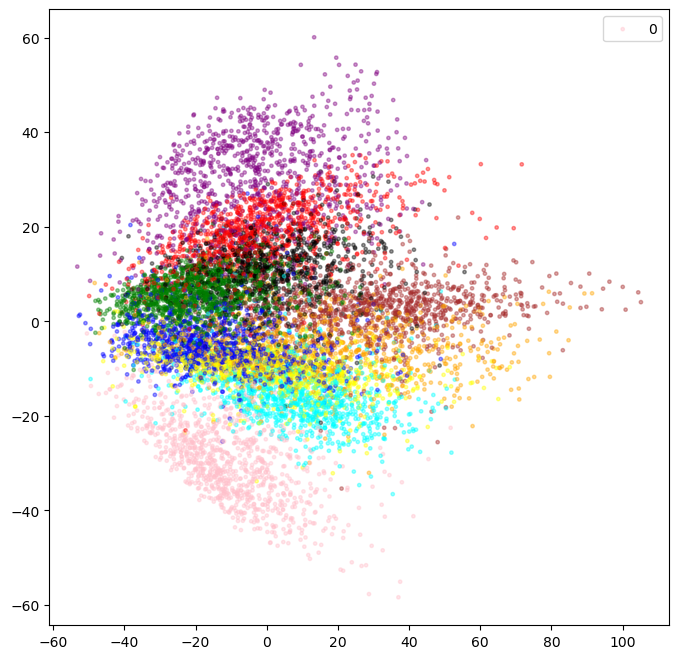

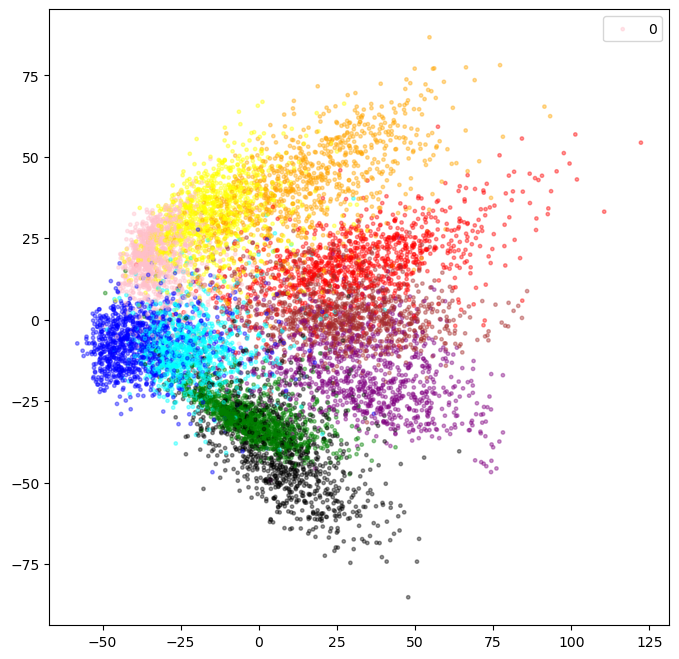

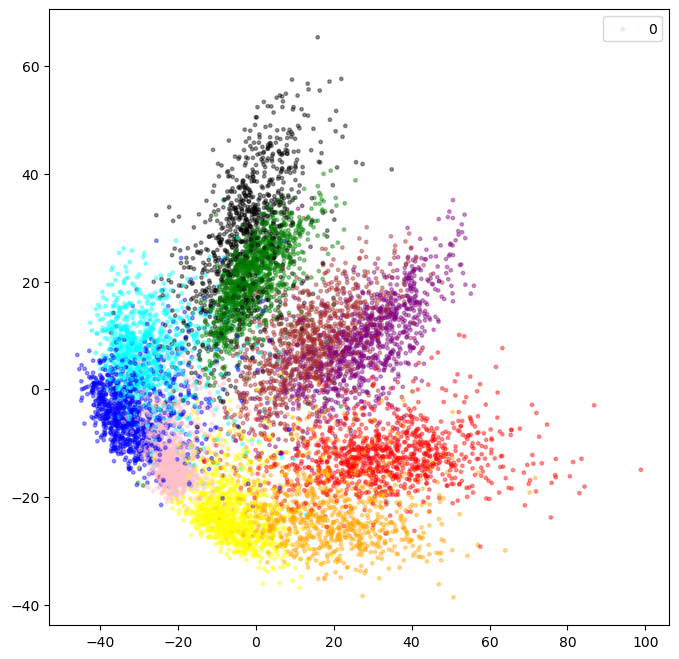

In [84]:
hidden_activities_transformed = []
for i in range(len(hidden_size)):
    hidden_activities_transformed.append(torch.cat([h[i] for h in hidden_activities]))


from sklearn.decomposition import PCA
from tqdm import tqdm
color_list = ['red', 'green', 'blue', 'yellow', 'black', 'orange', 'purple', 'pink', 'brown', 'cyan']
colors = [color_list[i] for i in all_labels]
pca = PCA(n_components=2)
for hat in hidden_activities_transformed:
    hat_pca = pca.fit_transform(hat.detach().numpy())
    plt.figure(figsize=(8,8))
    plt.scatter(hat_pca[:,0], hat_pca[:,1], s=6, c=colors, alpha=0.4)
    plt.legend()